In [46]:
%pip install torch torchvision pandas numpy matplotlib pillow seaborn scikit-learn opencv-python
%matplotlib inline


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
import xml.etree.ElementTree as ET

import seaborn as sns
from skimage import io

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


Define dataset paths and check image sizes

In [48]:
dataset_pth     = 'C:/MAMP/htdocs/2025_GP_27/model1/newDataset_images'
annotations_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/annotations'

print("Images dir exists:", os.path.isdir(dataset_pth))
print("Annots dir exists:", os.path.isdir(annotations_pth))

sizes = []

image_files = sorted([
    f for f in os.listdir(dataset_pth)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
])

for img_file in image_files[:50]:
    img_path = os.path.join(dataset_pth, img_file)
    with Image.open(img_path) as img:
        sizes.append(img.size)

unique_sizes = set(sizes)
print(f"Unique image sizes in sample: {unique_sizes}")
print(f"All images have same size: {len(unique_sizes) == 1}")
print(f"Images Count in sample: {len(sizes)}")


Images dir exists: True
Annots dir exists: True
Unique image sizes in sample: {(515, 255), (515, 258), (516, 257), (516, 260), (517, 258), (517, 255), (514, 256), (514, 259), (516, 259), (515, 257), (512, 255), (517, 260), (514, 258), (514, 255), (516, 258), (515, 256), (516, 255), (516, 261), (515, 259), (513, 256), (513, 259), (512, 257)}
All images have same size: False
Images Count in sample: 50


-Sets the folder for images and annotations.
-Checks that both directories exist.
-Looks at the first 50 images and prints their sizes and whether they all have the same resolution.
-This is just a sanity check to understand the raw data before preprocessing.

parse_xml_annotation → DataFrame

In [49]:
def parse_xml_annotation(xml_path):

    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        filename = root.find('filename').text
        filename = filename.strip()   

        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name is None:
                continue
            name = name.strip()

            bndbox = obj.find('bndbox')
            bbox = {
                'xmin': int(bndbox.find('xmin').text),
                'ymin': int(bndbox.find('ymin').text),
                'xmax': int(bndbox.find('xmax').text),
                'ymax': int(bndbox.find('ymax').text)
            }
            objects.append({'class': name, 'bbox': bbox})

        return {
            'filename': filename,
            'width': width,
            'height': height,
            'objects': objects
        }
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
        return None


-Reads an XML file for one image.

-Extracts image name, width, height.

-Extracts all objects (each has a class name and bounding box).

-Cleans text (removes tabs/newlines).

-Returns a Python dictionary or None if there is an error.

Build a DataFrame from all XML annotations

In [50]:
dataset_info = []

xml_files = sorted([
    f for f in os.listdir(annotations_pth)
    if f.lower().endswith('.xml')
])

print("Total XML files:", len(xml_files))

for xml_file in xml_files:
    xml_path = os.path.join(annotations_pth, xml_file)
    annotation = parse_xml_annotation(xml_path)

    if annotation:
        dataset_info.append({
            'image_name': annotation['filename'],
            'xml_path': xml_path,
            'width': annotation['width'],
            'height': annotation['height'],
            'num_objects': len(annotation['objects']),
            'objects': annotation['objects']
        })

df = pd.DataFrame(dataset_info)
print("Created DataFrame with", len(df), "rows")
df.head()


Total XML files: 3231
Created DataFrame with 3231 rows


,image_name,xml_path,width,height,num_objects,objects
0,000000.jpg,C:/MAMP/htdocs/2025_GP_27/model1/annotations\0...,514,259,2,"[{'class': 'Accumulation Flow', 'bbox': {'xmin..."
1,000001.jpg,C:/MAMP/htdocs/2025_GP_27/model1/annotations\0...,515,259,2,"[{'class': 'Accumulation Flow', 'bbox': {'xmin..."
2,000002.jpg,C:/MAMP/htdocs/2025_GP_27/model1/annotations\0...,515,258,2,"[{'class': 'Accumulation Flow', 'bbox': {'xmin..."
3,000003.jpg,C:/MAMP/htdocs/2025_GP_27/model1/annotations\0...,515,257,2,"[{'class': 'Accumulation Flow', 'bbox': {'xmin..."
4,000004.jpg,C:/MAMP/htdocs/2025_GP_27/model1/annotations\0...,516,258,2,"[{'class': 'Accumulation Flow', 'bbox': {'xmin..."


-Loops over all XML files in the annotations folder.

-Uses parse_xml_annotation to extract all information.

-Builds a list of dictionaries and converts it into a Pandas DataFrame df.

-Each row in df = one image with its annotation info.

Clean filenames, build full image paths, remove missing files

In [66]:
# Clean image_name from tabs/newlines/spaces
df['image_name'] = df['image_name'].astype(str)
df['image_name'] = df['image_name'].str.replace('\t', '', regex=False)
df['image_name'] = df['image_name'].str.strip()

# Build full image path
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(dataset_pth, x))

print("Sample image names and paths:")
print(df[['image_name', 'image_path']].head())

# Find images whose files do NOT actually exist on disk
missing = df[~df['image_path'].apply(os.path.exists)]
print("Number of missing image files:", len(missing))

if len(missing) > 0:
    print("Example of missing files:")
    print(missing[['image_name', 'image_path']].head())

# Remove rows with missing image files
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)
print("After removing missing images, total rows:", len(df))

# Double-check
missing_after = df[~df['image_path'].apply(os.path.exists)]
print("After cleaning, missing files:", len(missing_after))


Sample image names and paths:
   image_name                                         image_path
0  000000.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
1  000001.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2  000002.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
3  000003.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
4  000004.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
Number of missing image files: 0
After removing missing images, total rows: 2915
After cleaning, missing files: 0


Dataset Overview:
Total images (after cleaning): 2915
Total annotations: 5814

Class Distribution:
Normal Volume                564
Normal Flow                  564
Accumulation Flow            562
Volume                       562
Premature_cycling Flow       476
Premature_cycling Volume     460
Leakage Volume               452
Flow                         452
Ineffective_effort Volume    438
Ineffective_effort Flow      438
Double_Triggering Volume     424
Double_Triggering Flow       422
Name: count, dtype: int64


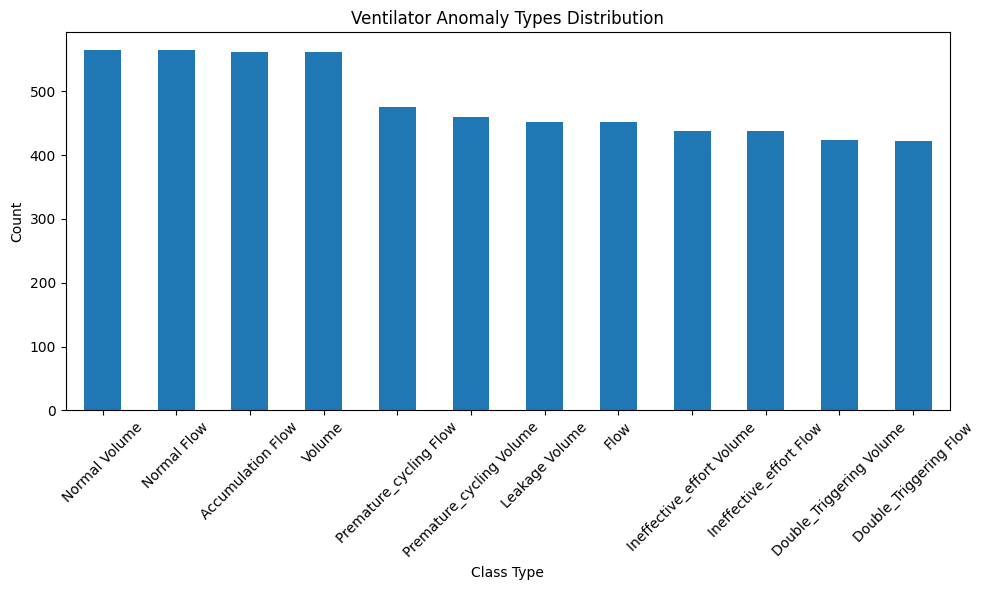

In [67]:
print("Dataset Overview:")
print(f"Total images (after cleaning): {len(df)}")
print(f"Total annotations: {df['num_objects'].sum()}")

all_classes = []
for objs in df['objects']:
    for obj in objs:
        all_classes.append(obj['class'])

class_counts = pd.Series(all_classes).value_counts()
print("\nClass Distribution:")
print(class_counts)

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Ventilator Anomaly Types Distribution')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


define clinical classes (Normal / Double / Ineffective)

In [68]:
CLINICAL_CLASSES = [
    "Normal",
    "Double_Triggering",
    "Ineffective_effort",
]
NUM_CLASSES = len(CLINICAL_CLASSES)
print("NUM_CLASSES =", NUM_CLASSES)

def map_raw_class_to_clinical(raw_name: str):

    if raw_name is None:
        return None
    name = raw_name.strip()

    if name.startswith("Normal "):
        return "Normal"
    if name.startswith("Double_Triggering "):
        return "Double_Triggering"
    if name.startswith("Ineffective_effort "):
        return "Ineffective_effort"

    return None


NUM_CLASSES = 3


Denoise Transform

In [69]:
# ---- Custom denoising transform (edge-preserving) ----
class DenoiseTransform:
    """
    Apply gentle, edge-preserving denoising using OpenCV fastNlMeansDenoisingColored.
    Input : PIL Image (RGB)
    Output: PIL Image (RGB) after noise reduction
    """
    def __call__(self, img_pil):
        # Convert PIL -> NumPy (RGB)
        img_np = np.array(img_pil)

        # OpenCV expects BGR, so convert if needed
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        # Apply gentle denoising (small h values to avoid over-smoothing)
        denoised_bgr = cv2.fastNlMeansDenoisingColored(
            img_bgr,
            None,
            h=5,          # luminance filter strength
            hColor=5,     # color filter strength
            templateWindowSize=7,
            searchWindowSize=21
        )

        # Back to RGB
        denoised_rgb = cv2.cvtColor(denoised_bgr, cv2.COLOR_BGR2RGB)

        # Convert back to PIL
        return Image.fromarray(denoised_rgb)


Defines the 3 clinical classes we care about for Tanafs.

Defines a mapping function that converts detailed raw labels like "Normal Flow" or "Double_Triggering Volume" into coarse labels: "Normal", "Double_Triggering", "Ineffective_effort".

Any other type (e.g., Accumulation, Premature_cycling) is ignored.

Create multi-label vectors and filter relevant images

In [70]:
def encode_clinical_labels(row, clinical_classes=CLINICAL_CLASSES):
   
    present = set()

    for obj in row['objects']:
        raw_name = obj.get('class', '')
        cls = map_raw_class_to_clinical(raw_name)
        if cls is not None:
            present.add(cls)

    label_vec = [1.0 if cls in present else 0.0 for cls in clinical_classes]
    return np.array(label_vec, dtype=np.float32)

df['clinical_label_vec'] = df.apply(encode_clinical_labels, axis=1)

mask_has_any = df['clinical_label_vec'].apply(lambda v: v.sum() > 0)
df_tanafs = df[mask_has_any].reset_index(drop=True)

print("Total samples used for Tanafs (Normal/Double/Ineffective):", len(df_tanafs))

label_matrix = np.stack(df_tanafs['clinical_label_vec'].values)  # [N, 3]
class_sums = label_matrix.sum(axis=0)

for cls_name, cnt in zip(CLINICAL_CLASSES, class_sums):
    print(f"{cls_name}: {int(cnt)} images")


Total samples used for Tanafs (Normal/Double/Ineffective): 1425
Normal: 564 images
Double_Triggering: 423 images
Ineffective_effort: 438 images


Builds a 3-element vector label for each image: [Normal, Double_Triggering, Ineffective_effort].

Keeps only images that contain at least one of these abnormalities (or normal).

Prints how many images there are in the final Tanafs subset for each clinical class.

Visual check for denoising effect

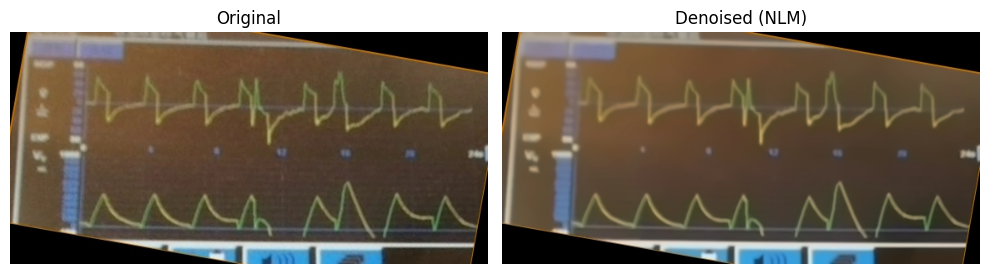

In [71]:
sample_img_path = df_tanafs.iloc[0]['image_path'] 
orig_pil = Image.open(sample_img_path).convert("RGB")

denoiser = DenoiseTransform()
denoised_pil = denoiser(orig_pil)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(orig_pil)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(denoised_pil)
plt.title("Denoised (NLM)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [72]:
import numpy as np

print("df_tanafs shape:", df_tanafs.shape)
print("Columns:", df_tanafs.columns)


def vec_to_single_id(vec):
    vec = np.array(vec)
    idxs = np.where(vec == 1)[0]
    if len(idxs) != 1:
        return -1
    return int(idxs[0])

df_tanafs['clinical_label_id'] = df_tanafs['clinical_label_vec'].apply(vec_to_single_id)

df_tanafs = df_tanafs[df_tanafs['clinical_label_id'] >= 0].reset_index(drop=True)

print(" Added clinical_label_id column.")
print("Unique clinical_label_id values:", df_tanafs['clinical_label_id'].unique())
print(df_tanafs[['image_name', 'clinical_label_vec', 'clinical_label_id']].head())


df_tanafs shape: (1425, 8)
Columns: Index(['image_name', 'xml_path', 'width', 'height', 'num_objects', 'objects',
       'image_path', 'clinical_label_vec'],
      dtype='object')
 Added clinical_label_id column.
Unique clinical_label_id values: [1 2 0]
   image_name clinical_label_vec  clinical_label_id
0  000888.jpg    [0.0, 1.0, 0.0]                  1
1  000890.jpg    [0.0, 1.0, 0.0]                  1
2  000891.jpg    [0.0, 1.0, 0.0]                  1
3  000892.jpg    [0.0, 1.0, 0.0]                  1
4  000893.jpg    [0.0, 1.0, 0.0]                  1


Split into train, validation, and test sets

In [73]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df_tanafs,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=df_tanafs['clinical_label_id']  
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=temp_df['clinical_label_id']    
)


print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Train: 997 Val: 214 Test: 214


plits the cleaned and filtered dataset into:

70% training

15% validation

15% test


 Define image transforms (resize, normalize, augment)

In [75]:
IMG_SIZE = 224  

train_transform = transforms.Compose([
    # 1) Resize to fixed size for the CNN
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    
    # 2) Apply gentle noise reduction (edge-preserving)
    DenoiseTransform(),
    
    # 3) Data augmentation (only for training)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    
    # 4) Convert to tensor [0,1]
    transforms.ToTensor(),
    
    # 5) Normalize with ImageNet stats (needed for transfer learning)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]    
    ),
])
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    DenoiseTransform(),   # optional but preferred for medical images
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

Create custom Dataset and DataLoaders

In [76]:
class TanafsClinicalDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = row['image_path']

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_id = int(row['clinical_label_id'])

        labels = torch.tensor(label_id, dtype=torch.long)

        return image, labels



BATCH_SIZE = 16

train_dataset = TanafsClinicalDataset(train_df, transform=train_transform)
val_dataset   = TanafsClinicalDataset(val_df,   transform=val_test_transform)
test_dataset  = TanafsClinicalDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [77]:
images, labels = next(iter(train_loader))
print("Images shape:", images.shape)   
print("Labels shape:", labels.shape)   
print("First label vector:", labels[0])


Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
First label vector: tensor(1)


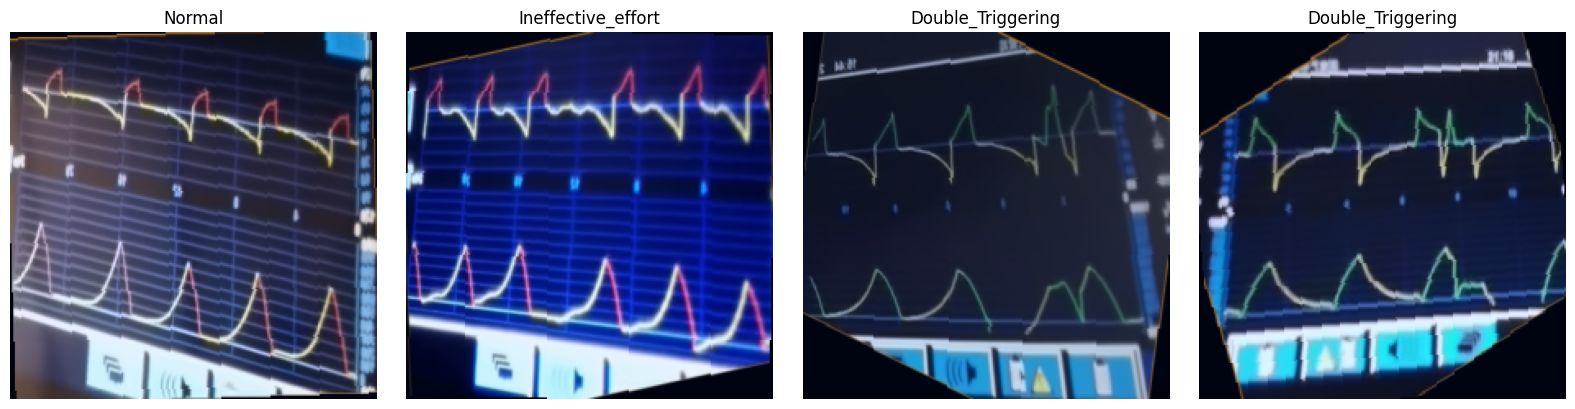

In [78]:

def show_batch(images, labels, classes, n=4):
  
    # Denormalize (approx) just for visualization
    imgs = images[:n].clone()
    imgs = imgs.permute(0, 2, 3, 1)  # [B, H, W, 3]

    plt.figure(figsize=(4 * n, 4))
    
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = imgs[i].numpy()
        
        # put valid range for display
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        ax.imshow(img)

        cls_id = int(labels[i].item())        
        cls_name = classes[cls_id]             

        ax.set_title(cls_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
images, labels = next(iter(train_loader))


show_batch(images, labels, CLINICAL_CLASSES, n=4)
